## Notebook 3 - Machine Learning para clasificación | Modelo KNN

En esta notebook nos enfocaremos en el workflow general que se realiza para crear, aplicar y evaluar un algoritmo de clasificación a un dataset. Los pasos siguientes, exceptuando las especificidades propias de cada modelo, son generalizables para otros tipos de algoritmos de clasificación: Decision Trees, XGBoost Classifier, SVM, etc.

* [Breve introducción al algoritmo](#)
* [Pretratamiento de datos, creación del modelo y training](#)
* [Predicción y evaluación del modelo](#)
  * [Métricas](#)
  * [Dummy Classifiers](#)
* [Feature selection](#)
* [Validation sets](#)
* [K-Fold Cross Validation](#)
* [Hyperparameter Tuning](#)
* [Modelo final](#)

## Clasificacion de Vinos:  ¿Es blanco o tinto?
<a id="1"></a>




Hay varios modelos diferentes para usar para la clasificación y cada uno tiene sus beneficios y limitaciones. Vamos a predecir el tipo de vino (tinto o blanco) usando el modelo de K-Nearest Neighbors (KNN).

Este algoritmo puede clasificar las diferentes clases, por ejemplo tinto o blanco, según lo cerca que estén sus atributos entre sí. 

El algoritmo KNN consiste en:

Tomar un conjunto de datos (en este caso el dataset de vinos: $X$)  y un conjunto de etiquetas (tinto o blanco: $y$), y a partir de información conocida quiero predecir que es lo que le corresponderia a un vino desconocido $x_{i}$. Entonces:

1. Calcular la proximidad del vino $x_{i}$ a todos los que están en $X$ (usando alguna funcion de distancia)


2. Seleccionamos los K puntos que esten más próximos a $X$ (K es hiperparámetro) 

3. Nos fijamos la etiqueta que tienen esos K puntos y predecimos que $x$ tiene la etiqueta más frecuente (como una especie de votación, la etiqueta más frecuente es la que término asignando a $x$)

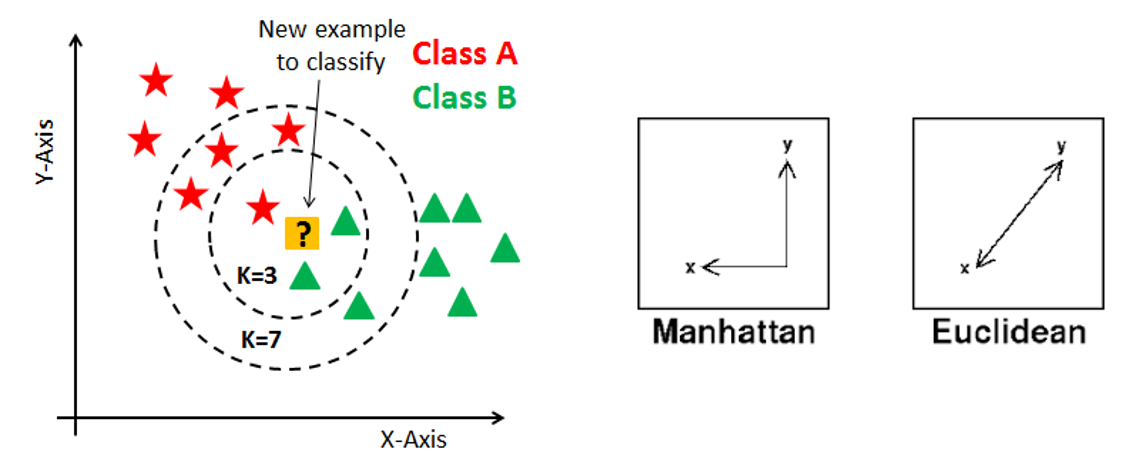

## Pretratamiento de datos, creación del modelo y training


Primero, hay que importar los conjuntos de datos de vino tinto y blanco y concatenarlos.


In [ ]:
import pandas as pd

df_red = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv", delimiter=";")
df_red['hue'] = '1'
df_white = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv", delimiter=";")
df_white['hue'] = '0'

df_wine = pd.concat([df_red, df_white], ignore_index=True)
df_wine

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,hue
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5,1
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5,1
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5,1
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6,1
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6492,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,6,0
6493,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,5,0
6494,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,6,0
6495,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,7,0


Ahora voy a "shufflear" el dataset, es decir, ordenar las filas de forma aleatoria y que no haya un patrón o sesgo en el orden de alguna feature, como por ejemplo el color (0, 0, 0, 0, ...., 1, 1, 1, 1)

In [ ]:
df_wine = df_wine.sample(frac=1, random_state = 42)
df_wine

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,hue
3103,7.0,0.17,0.74,12.80,0.045,24.0,126.0,0.99420,3.26,0.38,12.2,8,0
1419,7.7,0.64,0.21,2.20,0.077,32.0,133.0,0.99560,3.27,0.45,9.9,5,1
4761,6.8,0.39,0.34,7.40,0.020,38.0,133.0,0.99212,3.18,0.44,12.0,7,0
4690,6.3,0.28,0.47,11.20,0.040,61.0,183.0,0.99592,3.12,0.51,9.5,6,0
4032,7.4,0.35,0.20,13.90,0.054,63.0,229.0,0.99888,3.11,0.50,8.9,6,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3772,7.6,0.32,0.58,16.75,0.050,43.0,163.0,0.99990,3.15,0.54,9.2,5,0
5191,5.6,0.28,0.27,3.90,0.043,52.0,158.0,0.99202,3.35,0.44,10.7,7,0
5226,6.4,0.37,0.20,5.60,0.117,61.0,183.0,0.99459,3.24,0.43,9.5,5,0
5390,6.5,0.26,0.50,8.00,0.051,46.0,197.0,0.99536,3.18,0.47,9.5,5,0


Lo siguiente que vamos a hacer es dividir nuestros datos en un conjunto de datos de entrenamiento (**train set**) y datos de testeo (**test set**), usando la misma función.
En este caso, el conjunto de entrenamiento es el 67% de los datos y el conjunto de testeo el 33%. 


El **train set** se utiliza para entrenar al modelo: el algoritmo acá descubre patrones, tendencias y correlaciones en los datos que le sirven para clasificar correctamente a los datos. 

El **test set** se utiliza para evaluar el modelo entrenado en la etapa de training. Permite evaluar la generalidad del algoritmo en datos que NO vió y asegurarse así que no haya ningún tipo de sesgo posible. Permite además detectar presencia de overfitting si existe mucha diferencia entre el train y el test score.


In [ ]:
from sklearn.model_selection import train_test_split

X = df_wine.drop(['hue'], axis=1)
y = df_wine['hue']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state = 42) # dejar fijo el random_state permite que el split sea siempre el mismo y así
                                                                                           # lograr reproducibilidad. Puede ser cualquier número, a veces se pone 42                                                                  # por costumbre.

Para hacer mejores predicciones, vamos a normalizar los datos de las atributos de los vinos usando la función `StandardScaler()`. ¿Pero por qué estandarizar los datos hará que el modelo prediga mejor? Bueno, la respuesta depende del modelo. Hay algunos algoritmos que lo requieren y otros no. KNN es uno de ellos. La explicación de este hecho la podemos encontrar en [StackExchange](https://stats.stackexchange.com/questions/287425/why-do-you-need-to-scale-data-in-knn#:~:text=This%20is%20because%20the%20distance,the%20outcome%20of%20the%20KNN.&text=Save%20this%20answer.,-Show%20activity%20on).

Si los rangos de las features que estamos utilizandos para hacer el KNN difieren significativamente, las distancias entre los puntos tendrán cierto sesgo pudiendo llevar a resultados erróneos.

Veamos el siguiente ejemplo de clasificación entre 2 clases: azul y roja. Queremos asignar el punto negro (que ya sabemos que es azul). Sin la estandarización tiene más vecinos rojos que azules. Con la estandarización ocurre lo contrario. 



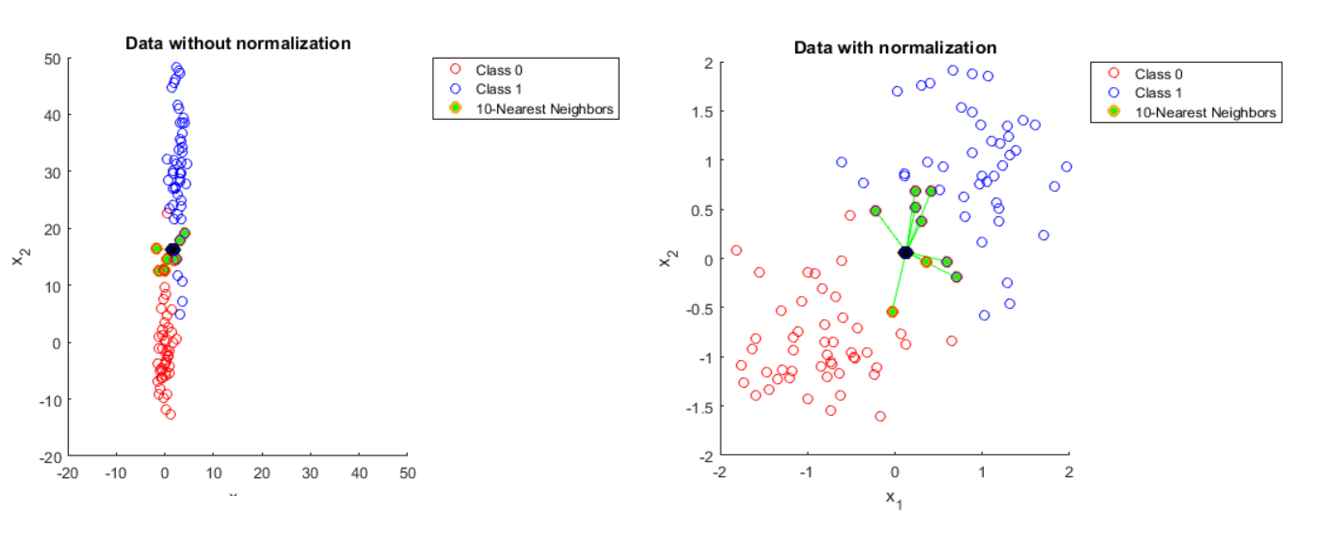



In [ ]:
from sklearn import preprocessing

scaler = preprocessing.StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)


Ahora, importamos Scikit Learn y creamos el KNeighborsClassifier desde la biblioteca sklearn.neighbors. Para declarar el clasificador tenemos que indicar el parámetro n_vecinos, este es el valor K y podría ser, por ejemplo, 3. En KNN, K es el número de vecinos más cercanos. Elegir el número "correcto" es importante, no solo porque el algoritmo requiere dicho parámetro, sino también porque el número apropiado de vecinos más cercanos determina el rendimiento del modelo.


In [ ]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors = 3)

Ajustamos los datos de entrenamiento al modelo con la función `knn.fit( ... , ... )`.

In [ ]:
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3)

## Predicción y evaluación del modelo: Métricas
Ahora que tenemos nuestro modelo entrenado, lo siguiente que debemos hacer es evaluar las predicciones hechas por él. Para hacerlo, vamos a predecir si un vino es blanco o tinto usando un vino del conjunto datos de testeo usando la función `predict()`. Despues, usamos esas predicciones para calcular la precisión, hacer la matriz de confusión y un informe de clasificación.


### Accuracy

In [ ]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay

y_pred = knn.predict(X_test)

print("Accuracy score: " + str(accuracy_score(y_test, y_pred)))

Accuracy score: 0.9911421911421912


### Confusion Matrix

La matriz de confusión es una herramienta que nos muestra el desempeño de un algoritmo de clasificación, describiendo cómo se distribuyen los valores reales y nuestras predicciones. Cada columna de la matriz representa el número de predicciones de cada clase, mientras que cada fila representa a las instancias en la clase real. La diagonal principal contiene la suma de todas las predicciones correctas. 

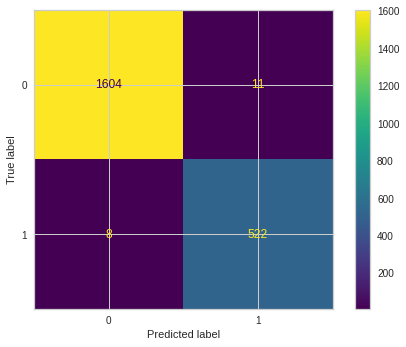

In [ ]:
import matplotlib.pyplot as plt
cm = confusion_matrix(y_test, y_pred, labels=knn.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=knn.classes_)
disp.plot()
plt.show()

### Classification Report

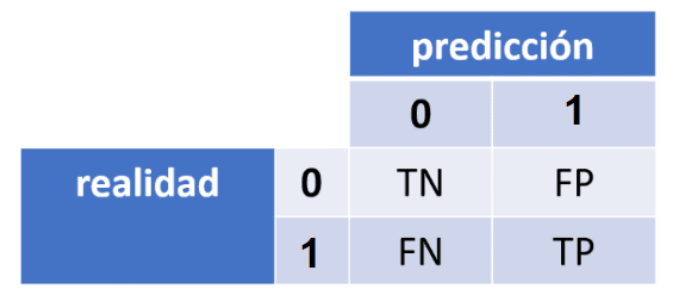

Lo que se analiza en el reporte de clasificación, son medidas que se calculan a partir de la matriz de confusión:

* Precisión nos da la calidad de la predicción: ¿qué porcentaje de los que hemos dicho que son la clase de vinos tintos, en realidad lo son?

  $Precisión = \frac{TP}{TP+FP}$

* Recall nos da la cantidad: ¿qué porcentaje de la clase de vinos tintos hemos sido capaces de identificar?

  $Recall = \frac{TP}{TP+FN}$

* F1 combina Precision y Recall en una sola medida, cuanto mas cerca del 1 mejor. 

  $F1 = 2* \frac{Precisión * Recall}{Precisión + Recall}$

* La exactitud (accuracy) mide el porcentaje de casos que el modelo ha acertado

  $Accuracy = \frac{TP+TN}{TP+TN+FP+FN}$

In [ ]:
print("\nClassification report: \n" + str(classification_report(y_test, y_pred)))


Classification report: 
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      1615
           1       0.98      0.98      0.98       530

    accuracy                           0.99      2145
   macro avg       0.99      0.99      0.99      2145
weighted avg       0.99      0.99      0.99      2145



### Dummy Classifiers

¿Cómo sabemos que la accuracy es buena? ¿Contra qué la comparamos? En este caso particular un 98% no deja dudas de que la clasificación es excelente. Pero si hubiera sido un 75% o un 70%, sigue siendo buena? Para corroborar esto recurrimos a un Dummy Classifier. Esto es un algoritmo que siempre predice la misma clase o que "adivina", es decir, asigna equiprobabilidad a cada clase. 

In [ ]:
from sklearn.dummy import DummyClassifier

dummy_classifier = DummyClassifier(strategy="most_frequent")
dummy_classifier.fit(X_train, y_train)
print(f"Accuracy del dummy classifier: "
      f"{dummy_classifier.score(X_test, y_test):.3f}")

Accuracy del dummy classifier: 0.753


El dummy classifier da una accuracy de 74% porque las clases no están balanceadas, hay muchos más vinos blancos que tintos.

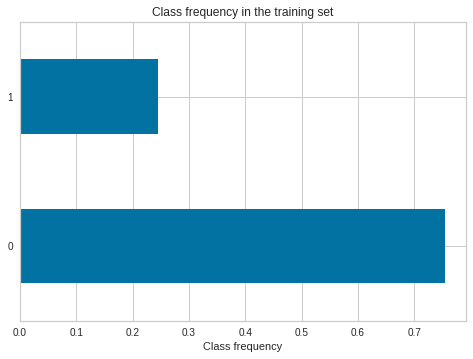

In [ ]:
import matplotlib.pyplot as plt
y_train.value_counts(normalize=True).plot.barh()
plt.xlabel("Class frequency")
_ = plt.title("Class frequency in the training set")

Una accuracy de 98% mejora notablemente una de 74% con un algoritmo que predice siempre la misma clase. Podemos concluir entonces que el modelo está aprendiendo de los datos.

## Feature selection
Una accuracy tan alta sin cambiar un poco el modelo o el dataset nunca (o casi nunca) va a ocurrir en casos reales. Por eso ahora vamos a ver algunas de las estrategias para mejorar la performance del modelo, empezando por una de las más importantes: feature selection. 

Buscamos con esta técnica quedarnos con las variables más importantes, las que aporten mayor cantidad de información al modelo o pesen más en el accuracy score. Algunas features pueden introducir correlación espúrea o ser muy poco importantes y por eso resulta imprescindible eliminarlas.

La feature selection la debemos realizar sobre todo el dataset para asegurarnos de tener la mayor cantidad de información posible a la hora de realizar la decisión de qué features eliminar.


### Select K Best
Hay varios métodos de feature selection. Select K Best realiza tests estadísticos y las variables con mayor score resultan las más importantes

In [ ]:
X_feature = df_wine.drop(['hue'], axis=1)
X_feature_scaled = scaler.fit_transform(X_feature)


In [ ]:
from sklearn.feature_selection import SelectKBest
selector = SelectKBest(k = 8)
X_k_best = selector.fit_transform(X_feature_scaled, y)
knn_feature = KNeighborsClassifier(3)
knn_feature.fit(X_k_best, y)

KNeighborsClassifier(n_neighbors=3)

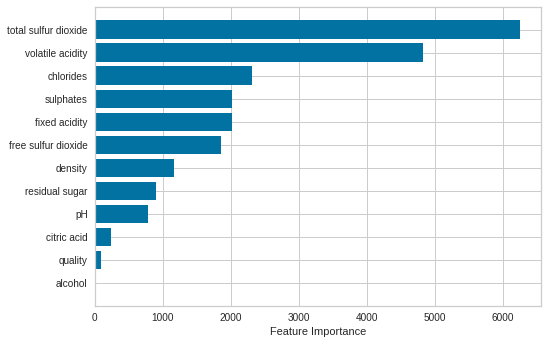

In [ ]:
scores = selector.scores_
feature_importance = pd.DataFrame({"feature_name": X.columns, "score": scores})

feature_importance = feature_importance.sort_values(by="score", ascending=True)

plt.barh(y=feature_importance["feature_name"], width=feature_importance["score"])
plt.xlabel("Feature Importance")
plt.show()

In [ ]:
# Ahora elimino las menos importantes: alcohol, quality y citric acid. 
X_reduced = X_feature.drop(columns = ["alcohol", "quality", "citric acid"])
X_reduced.head()

,fixed acidity,volatile acidity,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates
3103,7.0,0.17,12.8,0.045,24.0,126.0,0.99420,3.26,0.38
1419,7.7,0.64,2.2,0.077,32.0,133.0,0.99560,3.27,0.45
4761,6.8,0.39,7.4,0.020,38.0,133.0,0.99212,3.18,0.44
4690,6.3,0.28,11.2,0.040,61.0,183.0,0.99592,3.12,0.51
4032,7.4,0.35,13.9,0.054,63.0,229.0,0.99888,3.11,0.50


In [ ]:
# Hago el train test split de nuevo
X_reduced_train, X_reduced_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.33, random_state=42)
X_reduced_train = scaler.fit_transform(X_reduced_train)
X_reduced_test = scaler.fit_transform(X_reduced_test)

## Validation sets
Cuando dividimos el dataset en train set y test set se nos presenta el siguiente problema: solo tenemos un set para obtener una métrica insesgada de la performance de nuestro modelo (ya que testear sobre el train set necesariamente resulta en overfitting). Al obtener solo la accuracy del test set se nos imposibilita:

*   Cambiar hiperparámetros para mejorar la performance: solo dan más overfitting pues los tuneamos en función de lo que obtenemos evaluando el test set.
*   Obtener una estimación robusta de la performance y detectar tempranamente la presencia de overfitting.

Es en ese momento donde aparecen los validation set:

*   **Validation set**: se utiliza para evaluar la performance durante el training, tunear los hiperparámetros y elegir la mejor arquitectura para el modelo. 
*   **Test set**: se utiliza para evaluar la performance final del modelo, luego de que se haya completado el training. Permite computar métricas en data que el modelo NO haya visto y así determinar su generalidad. 

En ese sentido, resulta conveniente dividir el dataset en 3: training, validation y test. Sin embargo, hacer esto puede ser perjudicial si nuestro dataset es pequeño, pues cada vez tenemos menos data para entrenar el modelo. Por eso ahora vamos a ver una técnica llamada cross validation que permite usar mucha data tanto para training como para validation. 



## K-Fold Cross-Validation

Recordemos el split inicial que hicimos: 67% training set y 33% test set. Con la técnica cross validation todo el training set se va a utilizar no solo para entrenar sino también para validar. ¿Cómo? En K-fold cross validation se divide el training set en K subsets. En cada iteración, 1 de los K subsets será un validation set y el resto, K-1, training sets. De esta manera, todas las observaciones del 67% de la data se usarán en algún momento para entrenar y, en otro, para validar. 

Esto permite obtener una estimación robusta de la performance del modelo dado que promediamos la accuracy obtenida en cada validation set. Además, permite detectar tempranamente el overfitting a través de la comparación entre las accuracies del training y validation set.

Esquemáticamente (https://scikit-learn.org/stable/modules/cross_validation.html)

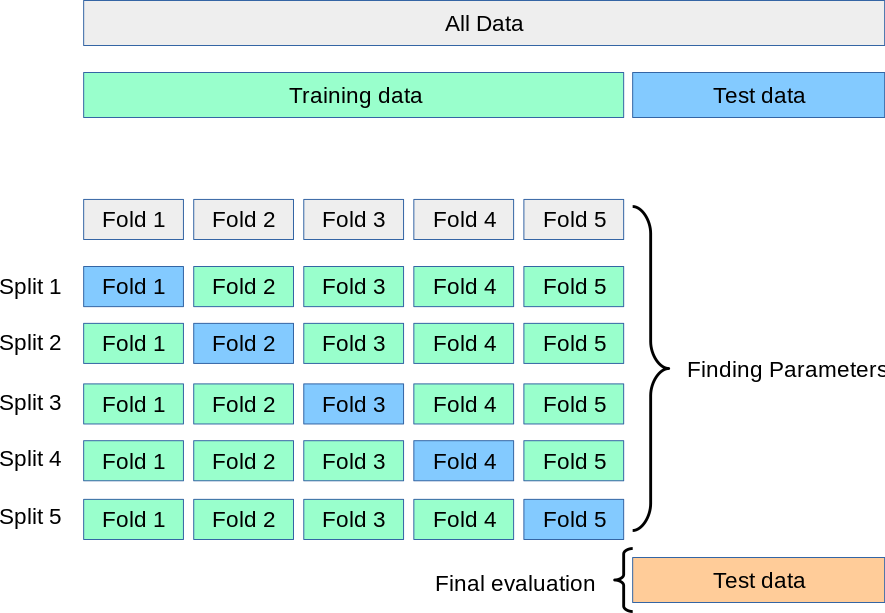

In [ ]:
from sklearn.model_selection import cross_validate
cv_result = cross_validate(knn, X_reduced_train, y_train, cv=5, return_train_score = True)
cv_result

{'fit_time': array([0.01156735, 0.00675035, 0.00670338, 0.00697303, 0.00717735]),
 'score_time': array([0.04812169, 0.04163527, 0.04334188, 0.04890919, 0.0440855 ]),
 'test_score': array([0.99311137, 0.99311137, 0.99195402, 0.9954023 , 0.99310345]),
 'train_score': array([0.99569089, 0.99683999, 0.9965537 , 0.99626651, 0.99511775])}

In [ ]:
scores = cv_result["test_score"]
print("La accuracy promedio del cross-validation es: "
    f"{scores.mean():.3f} ± {scores.std():.3f}"
)

La accuracy promedio del cross-validation es: 0.993 ± 0.001


Ahora con este modelo podemos buscar los hiperparámetros óptimos y despues ver de aplicar el módelo al test set.

## Hyperparameter Tuning

KNN no solo tiene la k como hiperparámetro. También tiene otros, como *weights* que se encarga de otorgar pesos a los puntos. Lo importante es que en este modelo, y en cualquier otro, siempre hay una combinación de hiperparámetros que maximiza el score y queremos encontrarla.

Una opción para ello es hacer un *GridSearchCV*, es decir, armar una lista de valores para cada hiperparámetro y que el algoritmo vaya probando cada uno y computando el test score. Sin embargo, hiperparámetros que toman un continuo de valores pueden resultar computacionalmente muy costosos. Por eso, siempre es mejor realizar primero una Validation Curve para saber en qué rango vamos a estar buscando:

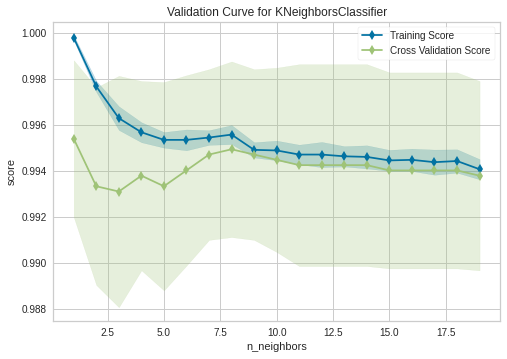

ValidationCurve(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7fc2ca83b1f0>,
                cv=10, estimator=KNeighborsClassifier(n_neighbors=3),
                param_name='n_neighbors',
                param_range=array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19]),
                scoring='accuracy')


In [ ]:
# OJO QUE ESTE CÓDIGO TARDA MUCHO EN CORRER #
import numpy as np
from yellowbrick.model_selection import validation_curve
print(validation_curve(knn, X_reduced_train, y_train, param_name="n_neighbors",
      param_range=np.arange(1, 20), cv=10, scoring="accuracy"))

¿Qué nos dice esta curva en términos de overfitting y underfitting? Notemos que el training score refiere a las accuracies computadas para el train set y el cross validation score para el test set, ambos sets obtenidos en el k-fold cross validation. Entonces:

*   Si ambas accuracies son bajas, hay underfitting.
*   Si el Training Score es mucho más alto que el Cross Validation Score, hay overfitting.
*   Si ambos scores son similares, hay un equilibrio correcto y el valor del parámetro seguramente permita que el modelo generalice correctamente cuando se haga la prueba en el test set.

En este sentido, a partir del valor k = 3 pareciera haber un buen compromiso entre overfitting y underfitting. Hagamos entonces un Grid Search CV con algunos de estos valores. Para más información acerca de qué hace cada hiperparámetro consultar la documentación: https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html


In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    "n_neighbors": [3, 5, 7, 9],
    "weights": ["uniform", "distance"],
    "p" : [1,2]
}
model_grid_search = GridSearchCV(
    knn, param_grid=param_grid, n_jobs=2, cv= 5, return_train_score = True
)
model_grid_search.fit(X_reduced_train, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(n_neighbors=3), n_jobs=2,
             param_grid={'n_neighbors': [3, 5, 7, 9], 'p': [1, 2],
                         'weights': ['uniform', 'distance']},
             return_train_score=True)

In [ ]:
cv_results = pd.DataFrame(model_grid_search.cv_results_)
cv_results.sort_values(by = "rank_test_score").head(3)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,param_p,param_weights,params,split0_test_score,split1_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
5,0.019288,0.007646,0.146533,0.025068,5,1,distance,"{'n_neighbors': 5, 'p': 1, 'weights': 'distance'}",0.998852,0.994259,...,0.996094,0.001867,1,0.999713,1.0,0.999713,0.999713,0.999713,0.99977,0.000115
9,0.012037,0.000438,0.081950,0.001821,7,1,distance,"{'n_neighbors': 7, 'p': 1, 'weights': 'distance'}",0.997704,0.991963,...,0.995864,0.002129,2,0.999713,1.0,0.999713,0.999713,0.999713,0.99977,0.000115
1,0.011898,0.000296,0.074236,0.006538,3,1,distance,"{'n_neighbors': 3, 'p': 1, 'weights': 'distance'}",0.995408,0.993111,...,0.995405,0.001623,3,0.999713,1.0,0.999713,0.999713,0.999713,0.99977,0.000115


In [ ]:
# Extraigamos el mejor de todos
cv_results[cv_results["rank_test_score"] == 1]["params"]

5    {'n_neighbors': 5, 'p': 1, 'weights': 'distance'}
Name: params, dtype: object

Si bien todos los test scores son muy parecidos y no parecería haber una combinación predilecta que destaque mucho por encima del resto, estrictamente hablando la mejor es aquella con k = 5, weights = "distance" y p = 1 (Manhattan distance).

¿Por qué a medida que aumenta k el modelo tiende a underfittear? Veamos de graficar los decision boundaries en 2D. Para ello, podemos mirar cuáles son las 2 features que mejor separan las clases. Un pairplot nos va a dar un análisis rápido:

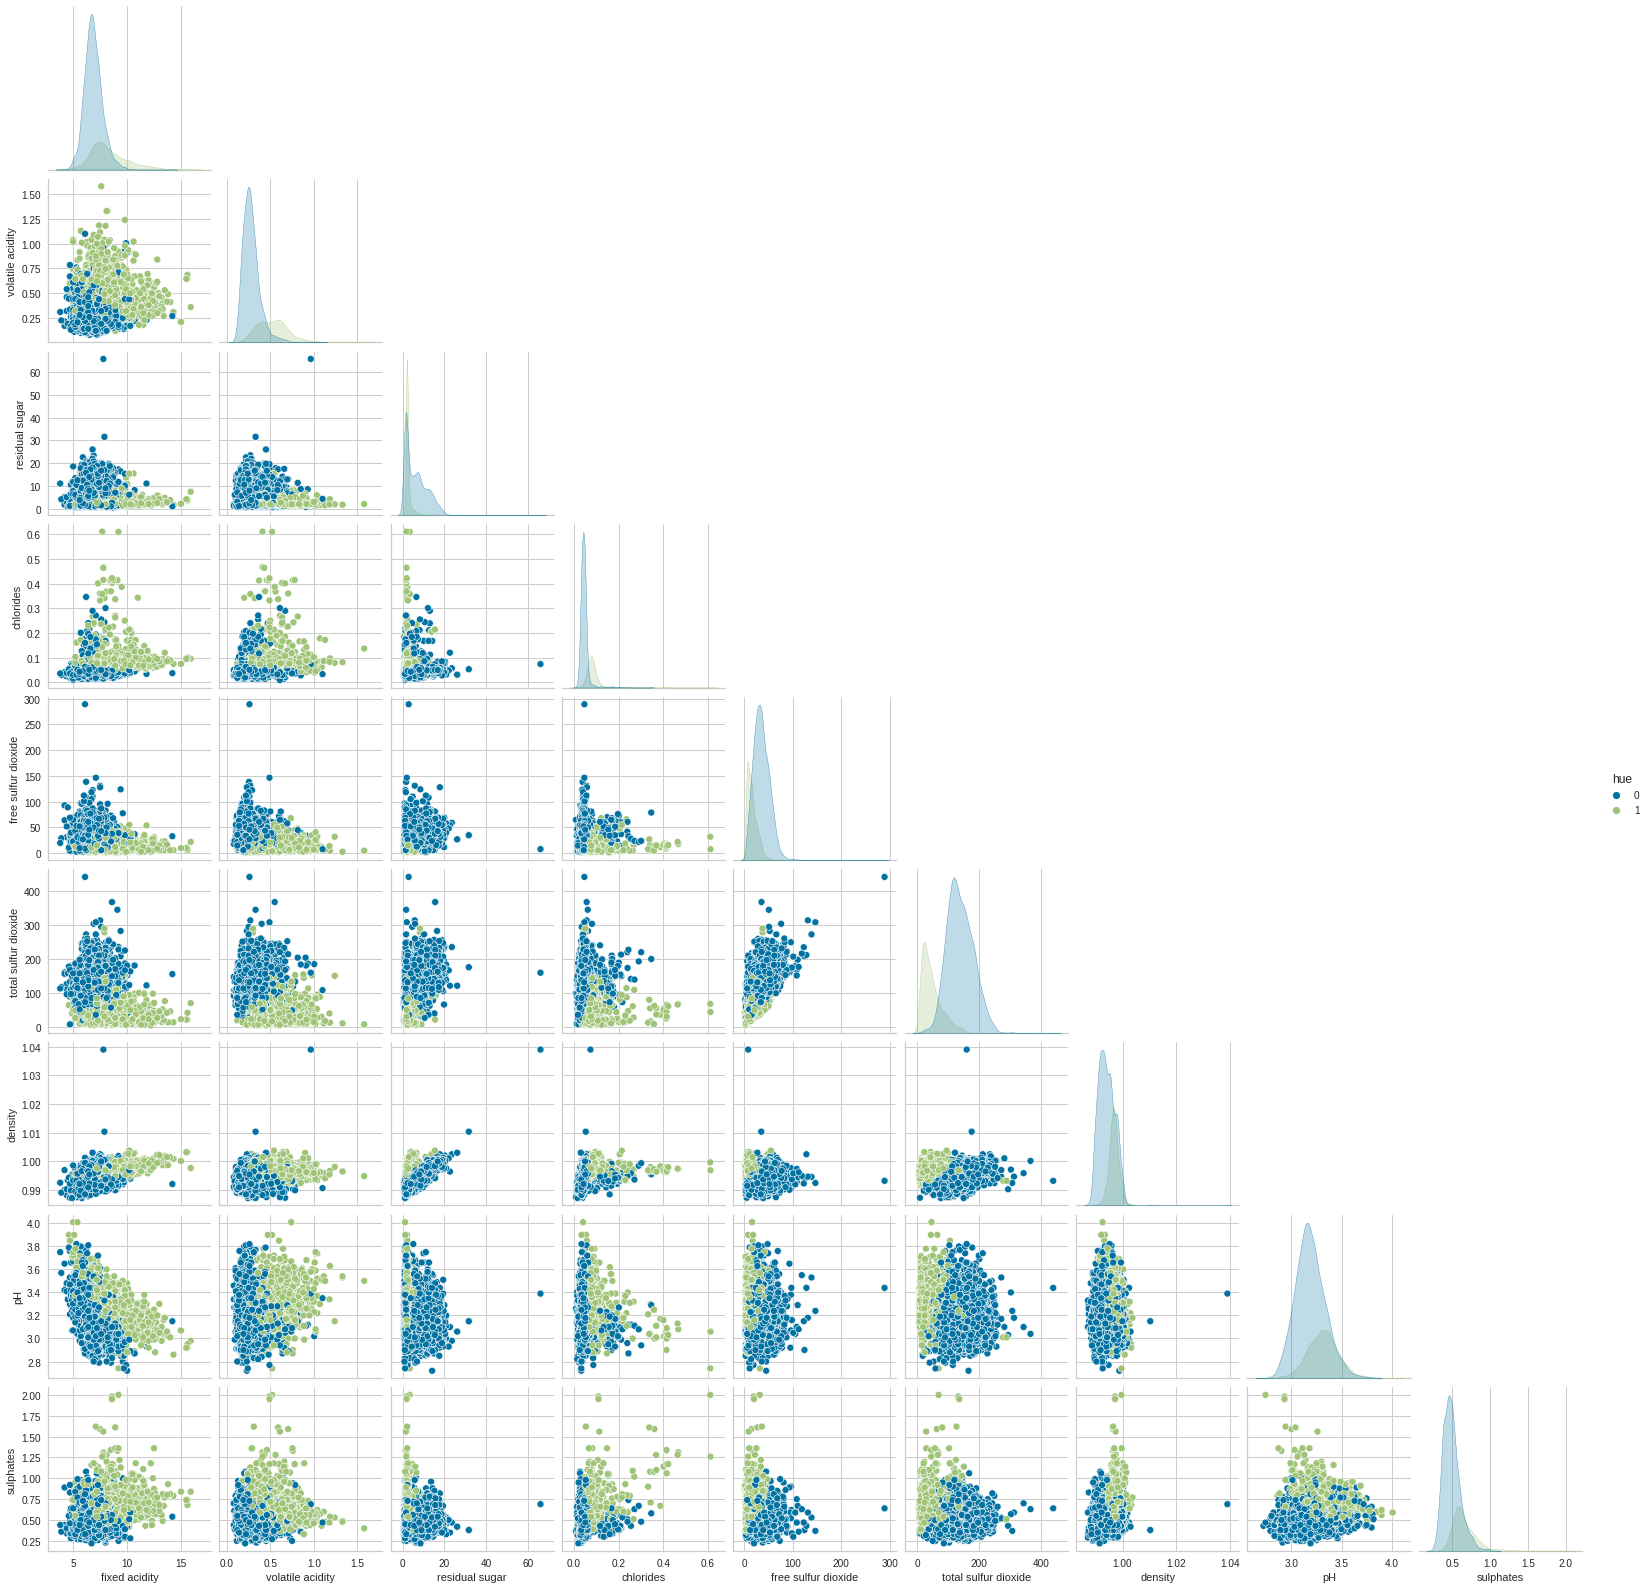

In [ ]:
import seaborn as sns
sns.pairplot(data = df_wine.drop(columns = ["citric acid", "alcohol", "quality"]), hue = "hue", corner = True)

Ningún grafico parece ser muy evidente el decision boundary, quizás aquel que grafica *sulphates* vs *chlorides*. Veamoslo más de cerca:

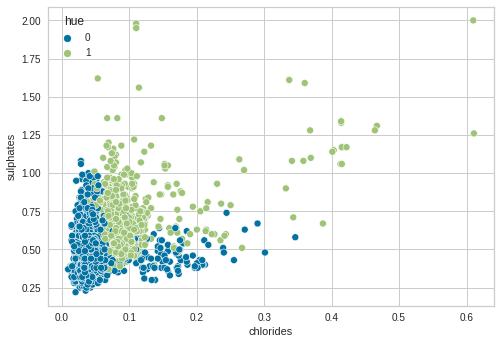

In [ ]:
sns.scatterplot(data = df_wine.drop(columns = ["citric acid", "alcohol", "quality"]), x = "chlorides", y = "sulphates", hue = "hue")

Ahora grafiquemos los límites de decisión:

In [ ]:
# Extraigo las variables de interés y las convierto en numpy arrays de 2D y 1D respectivamente
import numpy as np
X1 = df_wine[['chlorides', 'sulphates']]
y1 = df_wine['hue']
X1_array = np.array(X1.values)
y1_array = np.array(y1)


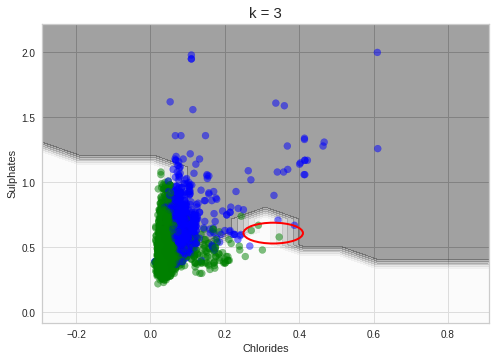

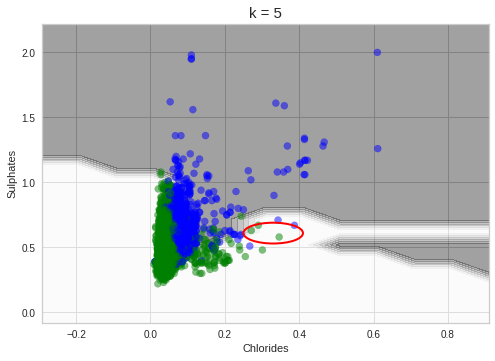

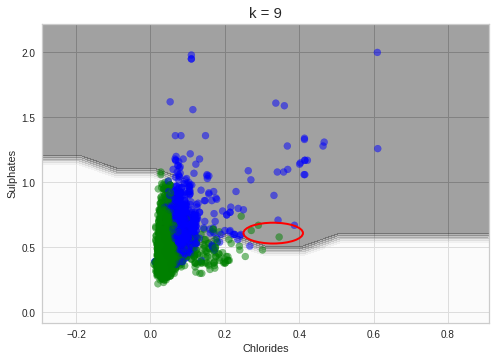

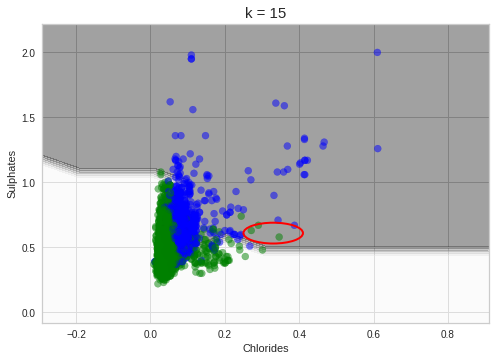

In [ ]:
# Hago lo mismo que antes: aplico knn ahora a estas dos features. En este caso hago un loop para visualizar el efecto de k.
X1_train, X1_test, y1_train, y1_test = train_test_split(X1_array, y1_array, random_state=42)
k_list = [3,5, 9, 15]
for number in k_list:
  knn_boundary = KNeighborsClassifier(n_neighbors=number)
  knn_boundary.fit(X1_train, y1_train)
  y1_pred = knn_boundary.predict(X1_test)
  accuracy = accuracy_score(y1_test, y1_pred)

  # Grafico decision boundary
  x_min, x_max = X1_array[:, 0].min() - 0.3, X1_array[:, 0].max() + 0.3
  y_min, y_max = X1_array[:, 1].min() - 0.3, X1_array[:, 1].max() + 0.3
  xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

  Z = knn_boundary.predict(np.c_[xx.ravel(), yy.ravel()])
  Z = Z.reshape(xx.shape)
  plt.contourf(xx, yy, Z, alpha=0.4)

  colors = y1_array
  colors = np.where(y1_array == '0', 'green', np.where(y1_array == '1', 'blue', colors))
  plt.scatter(X1_array[:, 0], X1_array[:, 1], c = colors, alpha=0.5)
  plt.xlabel("Chlorides")
  plt.ylabel("Sulphates")
  plt.title("k = " + str(number), fontsize = 15)
  #plt.text(0.5, 0.8, "Accuracy: " + str(round(accuracy, 3)))
  plt.gcf().gca().add_patch(plt.Circle((0.33, 0.61), 0.08, color='red', fill = False, linewidth = 2))
  #plt.gcf().gca().add_patch(plt.Circle((6.4, 0.7), 0.7, color='red', fill = False, linewidth = 2))
  plt.show()


## Modelo final

Con los resultados obtenidos, el mejor modelo debería ser aquel con k = 5, weight = distance y p = 1. Además, sabemos que con k = 9 no tenemos overfitting ni underfitting. En resumen, el worflow que realizamos es el siguiente:

https://scikit-learn.org/stable/modules/cross_validation.html 

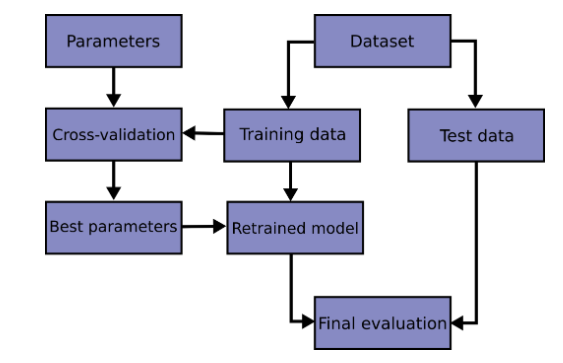

In [ ]:
knn_final = KNeighborsClassifier(n_neighbors = 5, weights = "distance", p = 1)
knn_final.fit(X_reduced_train, y_train)


y_pred_final = knn_final.predict(X_reduced_test)

print("Accuracy score: " + str(accuracy_score(y_test, y_pred_final)))
print("\nConfusion matrix: \n" + str(confusion_matrix(y_test, y_pred_final)))
print("\nClassification report: \n" + str(classification_report(y_test, y_pred_final)))



Accuracy score: 0.992074592074592

Confusion matrix: 
[[1606    9]
 [   8  522]]

Classification report: 
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      1615
           1       0.98      0.98      0.98       530

    accuracy                           0.99      2145
   macro avg       0.99      0.99      0.99      2145
weighted avg       0.99      0.99      0.99      2145

